In [1]:
import os
# from os import path
# import numpy as np
# import nibabel as nib
# from tqdm import tqdm
# from torch.utils.data import Dataset
# from glob import glob
# import random
import torch
# import torchio as tio
# import matplotlib.pyplot as plt
from dataset_tio import *
# import torchvision
# # from generator import GeneratorRRDB
# # from trainer_org import LitTrainer as LitTrainer_org
# # from trainer_gan import LitTrainer as LitTrainer_gan
# # from trainer_tune import LitTrainer as LitTrainer_tune
# import pytorch_lightning as pl
# # from discriminator import Discriminator
# # from feature_extractor import FeatureExtractor
# from torchvision.utils import save_image
# from torchsummary import summary
from models import GeneratorRRDB
# # from datasets import denormalize, mean, std
# import torch
# from torch.autograd import Variable
# import argparse
# import os
# from torchvision import transforms
# from torchvision.utils import save_image
# from PIL import Image
# print(os.getcwd())
import torchvision.transforms as transforms
import torchvision
import torch.nn as nn

In [2]:
%load_ext autoreload
%autoreload 2

In [21]:
std = 0.3548
channels = 1
residual_blocks = 1

root = '/mnt/beta/djboonstoppel/Code/esrgan'
exp_name = 'patch-based-no_upsample_1resblock//'
ckpth_fname = 'generator_35'
ckpth_path = os.path.join(root, exp_name, 'saved_models', ckpth_fname+'.pth')

In [22]:
# os.makedirs("images/outputs", exist_ok=True)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define model and load model checkpoint
generator = GeneratorRRDB(channels, filters=64, num_res_blocks=residual_blocks, num_upsample=0).to(device)
generator.load_state_dict(torch.load(ckpth_path))
generator.eval()

GeneratorRRDB(
  (conv1): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (res_blocks): Sequential(
    (0): ResidualInResidualDenseBlock(
      (dense_blocks): Sequential(
        (0): DenseResidualBlock(
          (b1): Sequential(
            (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            (1): LeakyReLU(negative_slope=0.01)
          )
          (b2): Sequential(
            (0): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            (1): LeakyReLU(negative_slope=0.01)
          )
          (b3): Sequential(
            (0): Conv2d(192, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            (1): LeakyReLU(negative_slope=0.01)
          )
          (b4): Sequential(
            (0): Conv2d(256, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            (1): LeakyReLU(negative_slope=0.01)
          )
          (b5): Sequential(
            (0): Conv2d(320, 64, kernel_size=(3, 3), stride=

In [23]:
test_subjects = data_split('test', patients_frac=1, root_dir='/mnt/beta/djboonstoppel/Code/data')

test_set = tio.SubjectsDataset(
    test_subjects, transform=Normalize(std=std))

Loading test set...


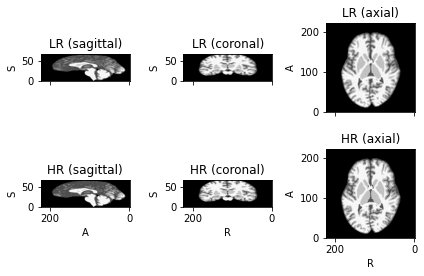

In [24]:
img_sim = ImagePair(number=100206, simulated=True, select_slices=70, root_dir='/mnt/beta/djboonstoppel/Code/data')
sim_subject = [img_sim.subject()]

sim_set = tio.SubjectsDataset(
    sim_subject, transform=Normalize(std=std))

sim_set[0].plot()

In [25]:
batch_size = 4
patch_size = (64,64)
ovl_perc = (.5, .5)
overlap, nr_patches = calculate_overlap(test_subjects[0]['LR'], patch_size, ovl_perc)

In [26]:
subject = sim_set[0]
grid_sampler = tio.inference.GridSampler(
    subject,
    patch_size=(*patch_size,1),
    # patch_overlap=(36,36,0),
    patch_overlap=overlap,
    padding_mode=0,
)

patch_loader = torch.utils.data.DataLoader(
    grid_sampler, batch_size=batch_size)

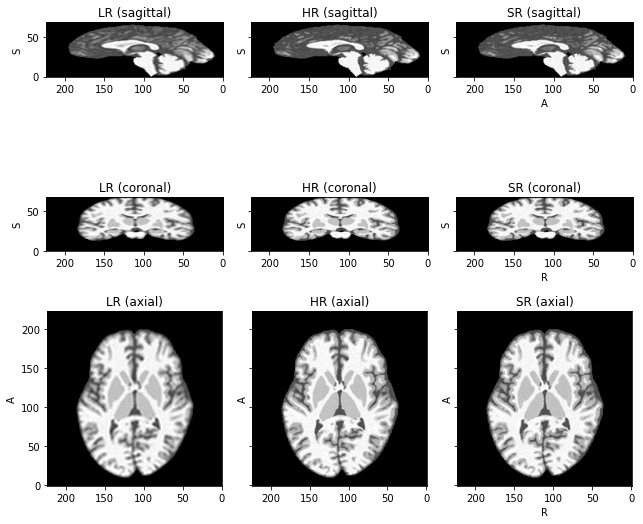

In [27]:
aggregator1 = tio.inference.GridAggregator(grid_sampler)#, overlap_mode='average')
# aggregator2 = tio.inference.GridAggregator(grid_sampler)#, overlap_mode='average')
with torch.no_grad():
    for patches_batch in patch_loader:
        imgs_lr, imgs_hr = patches_batch['LR'][tio.DATA].squeeze(4), patches_batch['HR'][tio.DATA].squeeze(4)
        # imgs_lr = transforms.functional.resize(imgs_lr, 16,
        #                                        interpolation=torchvision.transforms.InterpolationMode.BICUBIC)
        gen_hr = generator(imgs_lr.to(device)).unsqueeze(4)
        # imgs_lr = nn.functional.interpolate(imgs_lr, scale_factor=4).unsqueeze(4)
        locations = patches_batch[tio.LOCATION]
        aggregator1.add_batch(gen_hr, locations)
        # aggregator2.add_batch(imgs_lr, locations)

foreground1 = aggregator1.get_output_tensor()
# foreground2 = aggregator2.get_output_tensor()
torch.cuda.empty_cache()

generated = tio.ScalarImage(tensor=foreground1)
# LR_down = tio.ScalarImage(tensor=foreground2)
subject.add_image(generated, 'SR')
# subject.add_image(LR_down, 'LR_down')
subject.plot(figsize=(9, 8))

In [28]:
def re_scale(img, std, max_val):
    img *= std
    img *= max_val
    return img

def save_to_nifti(img, header, fname, std, max_val):
    affine = np.eye(4)
    affine[2,2] = 2
    img = img.numpy()[0]
    img = re_scale(img, std, max_val)
    img_nifti = nib.Nifti1Image(img, affine=affine, header=header)
    nib.save(img_nifti, fname)

def save_subject(subject, header, pref, std, max_vals, path='output'):
    save_to_nifti(img = subject['LR'],
                  header = header,
                  std = std,
                  max_val = max_vals[0],
                  fname = os.path.join(path, '{}_LR.nii.gz'.format(pref)),
                  )
    save_to_nifti(img = subject['HR'],
                  header = header,
                  std = std,
                  max_val = max_vals[1],
                  fname = os.path.join(path, '{}_HR.nii.gz'.format(pref)),
                  )
    save_to_nifti(img = subject['SR'],
                  header = header,
                  std = std,
                  max_val = max_vals[2],
                  fname = os.path.join(path, '{}_SR.nii.gz'.format(pref)),
                  )

In [29]:
output_path = os.path.join(root, exp_name, 'images', 'outputs')
os.makedirs(output_path, exist_ok=True)

fname ='patch-based-no_upsample_1resblock'

# name='100206'
std = std
max_vals = (
    img_sim.info()['LR']['scaling'],
    img_sim.info()['HR']['scaling'],
    img_sim.info()['LR']['scaling'],
    )
save_subject(subject=subject,
             header=img_sim.info()['LR']['header'],
             pref=fname,
             std=std,
             max_vals=max_vals,
             path=output_path,
             )

